# Analysis 1

We will be conducting a regression analysis to check the association between countries’ greenhouse gas emissions (independent variable) and their global climate risk indices (dependent variable).

In [21]:
import pandas as pd
import warnings
from sklearn.linear_model import Ridge
import statsmodels.regression.linear_model as sm
import statsmodels.tools.tools as t
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import zip_longest
import altair as alt

The greenhouse gas emissions include CO2 (fossil only), CH4, N2O and F-gases. They are combined using Global Warming Potential values from IPCC AR5. This data comes from the [Emissions Database for Global Atmospheric Research](https://edgar.jrc.ec.europa.eu/report_2023#data_download).


The [2020 global climate risk index](https://www.germanwatch.org/sites/default/files/20-2-01e%20Global%20Climate%20Risk%20Index%202020_14.pdf)  lists each country’s climate risk score and rank, and is published by a group called Germanwatch. This metric indicates a country's to-date exposure and level of susceptibility to climate-adjacent extreme events. The dataset can be found on pages 37 to 43 of the linked pdf. 


The [Paris Climate Agreement data](https://treaties.un.org/pages/ViewDetails.aspx?src=TREATY&mtdsg_no=XXVII-7-d&chapter=27&clang=_en) assigns each country one of the following values: "R" for Ratification, "A" for Acceptance, "AA" for Approval, "a" for Accession, or "None" for no participation. This data comes from the United Nations Treaty Collection.

In [2]:
# Reading in the data
climate_risk_dat = pd.read_csv("fetched_data/CRI.csv")

paris_agreement_dat = pd.read_csv("fetched_data/PARIS_AGREEMENT_DATA.csv")

greenhouse_gas_dat = pd.read_csv("fetched_data/GHG_DATA.csv")

In [3]:
# Checking column name representation prior to merging
print(climate_risk_dat.columns)
print(paris_agreement_dat.columns)
print(greenhouse_gas_dat.columns)

Index(['ID', 'Country_Name', 'CRI_RANK', 'CRI_SCORE', 'Fatalities_Rank',
       'Fatalities_per_100000_inhabitants_RANK', 'Losses_in_US_Million_Rank',
       'Losses_per_unit_GDP_Rank'],
      dtype='object')
Index(['Country_Name', 'Date_Joined'], dtype='object')
Index(['Country', 'GHG_Emissions'], dtype='object')


In [4]:
# Convert Country columns to string type
climate_risk_dat['Country_Name'] = climate_risk_dat['Country_Name'].astype("string")
paris_agreement_dat['Country_Name'] = paris_agreement_dat['Country_Name'].astype("string")
greenhouse_gas_dat['Country'] = greenhouse_gas_dat['Country'].astype("string")

In [5]:
# Looking for inconsistencies in how the countries are represented textually
cri = sorted(climate_risk_dat['Country_Name'])
ghg = sorted(greenhouse_gas_dat['Country'])
pa = sorted(paris_agreement_dat['Country_Name'])

for c1, c2, c3 in zip_longest(ghg, pa, cri, fillvalue = ''):
    print(f'{c1} {c2} {c3}')

Afghanistan                                                  Afghanistan                                                  Afghanistan                                                 
Albania                                                      Albania                                                      Albania                                                     
Algeria                                                      Algeria                                                      Algeria                                                     
Angola                                                       Andorra                                                      Angola                                                      
Anguilla                                                     Angola                                                       Antigua and Barbuda                                         
Antigua and Barbuda                                          Antigua and Barbuda     

In [6]:
# Change a country name to match the others
def alter_country_name(dataset, alter_dict, country_column_name):
    '''change country names in a dataset so it matches the values in other datasets
       example-- changing Brunei to Brunei Darussalam in one dataset so all datasets refer to Brunei in the same way

       INPUTS:
       dataset: dataset for which we are altering the country name
       change_dict: a dictionary where the key is country name we want to alter and the value is what we are changing to
       country_column_name: the column name of the column that contains countries

       RETURNS:
       altered dataset
       '''
    for original, changed in alter_dict.items():
        print(f"Changing {original} to {changed}") # Added print statement to check if right country names are being associated
        dataset[country_column_name] = dataset[country_column_name].str.strip() # This removes spaces on either side of the country name
        dataset.loc[dataset[country_column_name] == original, country_column_name] = changed
    return dataset

cr_data_matched = alter_country_name(climate_risk_dat, {'Cape Verde': 'Cabo Verde',
                                                        'Democratic Republic of Congo': 'Democratic Republic of the Congo',
                                                        'The Bahamas': 'Bahamas'
                                                       },
                                     "Country_Name")

paris_data_matched = alter_country_name(paris_agreement_dat, {'Timor Leste': 'Timor-Leste'},
                                        "Country_Name")

ghg_data_matched = alter_country_name(greenhouse_gas_dat, {'France and Monaco': 'France',
                                                           'Guinea-Bissau': 'Guinea Bissau',
                                                           'Israel and Palestine, State of': 'Israel',
                                                           'Italy, San Marino and the Holy See': 'Italy',
                                                           'United States': 'United States of America',
                                                           'Yemen': 'Republic of Yemen',
                                                           'Spain and Andorra': 'Spain',
                                                           'Switzerland and Liechtenstein': 'Switzerland'
                                                          },
                                      "Country")

Changing Cape Verde to Cabo Verde
Changing Democratic Republic of Congo to Democratic Republic of the Congo
Changing The Bahamas to Bahamas
Changing Timor Leste to Timor-Leste
Changing France and Monaco to France
Changing Guinea-Bissau to Guinea Bissau
Changing Israel and Palestine, State of to Israel
Changing Italy, San Marino and the Holy See to Italy
Changing United States to United States of America
Changing Yemen to Republic of Yemen
Changing Spain and Andorra to Spain
Changing Switzerland and Liechtenstein to Switzerland


The GHG dataset combines some countries together into a single row (e.g. 'Serbia and Montenegro'), while these countries are separate entities in the climate risk and GHG datasets. In the code below, all such cases in the GHG dataset are split into two distinct countries, each with their own row. Two previously paired countries are  assigned the same GHG emissions value (half of the aggregated value), since we do not have the resources to determine how much each country contributed to the aggregated values.

In [7]:
# Split countries that were combined into a single row in a dataset into two distinct rows, dividing the aggregated data equally between them
 
# Serbia and Montenegro
sm_index = ghg_data_matched[ghg_data_matched['Country'] == 'Serbia and Montenegro'].index

# Split emissions value in half
sm_emissions_val = ghg_data_matched.loc[sm_index, 'GHG_Emissions'].values[0] / 2

# Create new rows
sm_new_rows = pd.DataFrame([{'Country': 'Serbia', 'GHG_Emissions': sm_emissions_val},\
                            {'Country': 'Montenegro', 'GHG_Emissions': sm_emissions_val}])

# Append new rows to dataset
ghg_data_split = pd.concat([ghg_data_matched, sm_new_rows], ignore_index=True)

# Re-sort data and drop combined row
ghg_data_split = ghg_data_split[ghg_data_split['Country'] != 'Serbia and Montenegro']
ghg_data_split.sort_values(by = 'Country', inplace = True)



# Sudan and South Sudan
ssd_index = ghg_data_split[ghg_data_split['Country'] == 'Sudan and South Sudan'].index

# Split emissions value in half
ssd_emissions_val = ghg_data_split.loc[ssd_index, 'GHG_Emissions'].values[0] / 2

# Create new rows
ssd_new_rows = pd.DataFrame([{'Country': 'Sudan', 'GHG_Emissions': ssd_emissions_val},
                             {'Country': 'South Sudan', 'GHG_Emissions': ssd_emissions_val}])

# Append new rows to dataset
ghg_data_split = pd.concat([ghg_data_split, ssd_new_rows], ignore_index=True)

# Re-sort data and drop combined row
ghg_data_split = ghg_data_split[ghg_data_split['Country'] != 'Sudan and South Sudan']
ghg_data_split.sort_values(by = 'Country', inplace = True)

In [8]:
# Merging the required data into a single dataframe
merged_data = cr_data_matched.merge(paris_data_matched, how = "left", on = "Country_Name").merge(
    ghg_data_split, how = "left", left_on = ["Country_Name"], right_on = ["Country"])

In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ID                                      183 non-null    int64  
 1   Country_Name                            183 non-null    object 
 2   CRI_RANK                                183 non-null    int64  
 3   CRI_SCORE                               183 non-null    float64
 4   Fatalities_Rank                         183 non-null    int64  
 5   Fatalities_per_100000_inhabitants_RANK  183 non-null    int64  
 6   Losses_in_US_Million_Rank               183 non-null    int64  
 7   Losses_per_unit_GDP_Rank                183 non-null    int64  
 8   Date_Joined                             180 non-null    object 
 9   Country                                 178 non-null    object 
 10  GHG_Emissions                           178 non-null    float6



We opted to use CRI_SCORE rather than CRI_RANK as the dependent variable in our analysis for several reasons. 

Using CRI_RANK as the dependent variable would place more emphasis on the ordinal ranking of countries with respect to their climate risk, rather than the actual values of the indices. Additionally, the ranks would be discretized into categories, posing two distinct problems:
- All differences in climate rank would be treated equally, ignoring the magnitude of the differences between the actual values of countries' indices.
- Some countries with near-identical climate risk scores were given the same climate rank; the distinct climate risk scores for these countries would be combined into a single discrete category. This would precipitate a loss of information about each rank's climate variability, and potentially cause us to underestimate the complexity of the relationship between our dependent and independent variables.

In [10]:
# Select only the columns required for the analysis
simplified_data = merged_data[["Country_Name", "CRI_SCORE", "GHG_Emissions", "Date_Joined"]].rename(columns = {"Date_Joined":"Paris_Status"})
simplified_data.head(2)

,Country_Name,CRI_SCORE,GHG_Emissions,Paris_Status
0,Albania,108.00,3.145276,R
1,Algeria,93.83,6.540428,R


In [11]:
# Check for any missing data
simplified_data.isnull().sum()

Country_Name     0
CRI_SCORE        0
GHG_Emissions    5
Paris_Status     3
dtype: int64

In [12]:
# Check which rows are missing values
nan_rows = simplified_data.isna().any(axis=1)
#print(nan_rows)
simplified_data[simplified_data.isna().any(axis=1)]

,Country_Name,CRI_SCORE,GHG_Emissions,Paris_Status
33,Chinese Taipei,72.33,NaN,NaN
91,Tuvalu,125.00,NaN,R
109,Kosovo,125.00,NaN,NaN
126,Marshall Islands,125.00,NaN,R
130,Micronesia,125.00,NaN,R
155,Puerto Rico,107.67,4.428183,NaN


We decided to remove any countries that have no GHG emissions data or Paris Agreement data, since they will not be relevant to an analysis looking into the potential association between climate risk, and greenhouse gas emissions and paris agreement status.

In [22]:
# Drop columns where GHG_Emissions and Paris_Status are null
drop_countries = ['Chinese Taipei', 'Tuvalu', 'Kosovo', 'Marshall Islands', 'Micronesia', 'Puerto Rico']
simplified_data2 = simplified_data[~simplified_data['Country_Name'].isin(drop_countries)]
simplified_data2

,Country_Name,CRI_SCORE,GHG_Emissions,Paris_Status
0,Albania,108.00,3.145276,R
1,Algeria,93.83,6.540428,R
2,Angola,76.00,2.541601,R
3,Antigua and Barbuda,125.00,3.641680,R
4,Argentina,48.33,8.465010,R
...,...,...,...,...
178,St.Vincent and the Grenadines,125.00,1.559193,R
179,Sudan,49.33,1.333975,R
180,Suriname,125.00,5.826030,R
181,Sweden,89.00,6.346528,R


In [14]:
simplified_data2.isnull().sum()

Country_Name     0
CRI_SCORE        0
GHG_Emissions    0
Paris_Status     0
dtype: int64

We will one-hot-encode our paris agreement variable for ease of analysis. We will create a new column for each of the categories: 'A', 'AA', 'R', 'a', and 'None'.

In [15]:
one_hot_encoded_data = pd.get_dummies(simplified_data2, columns = ['Paris_Status']) 
one_hot_encoded_data[
        ['Paris_Status_A         ', 
         'Paris_Status_AA        ', 
         'Paris_Status_None      ', 
         'Paris_Status_R         ',
         'Paris_Status_a         ']] = one_hot_encoded_data[['Paris_Status_A         ', 
                                                             'Paris_Status_AA        ', 
                                                             'Paris_Status_None      ',
                                                             'Paris_Status_R         ',
                                                             'Paris_Status_a         ']].astype(int)

In [16]:
one_hot_encoded_data.dtypes

Country_Name                object
CRI_SCORE                  float64
GHG_Emissions              float64
Paris_Status_A               int64
Paris_Status_AA              int64
Paris_Status_None            int64
Paris_Status_R               int64
Paris_Status_a               int64
dtype: object

Now, we will split our data into X (independent variables) and y (dependent/target variable). We add a constant to act as an intercept for the linear regression fit.

In [17]:
X = one_hot_encoded_data.drop(columns = ["CRI_SCORE", "Country_Name"])
X = t.add_constant(X)
y = one_hot_encoded_data[["CRI_SCORE"]]

Now we will use linear regression and least-squares-estimation to fit a linear model to our data.

In [18]:
result = sm.OLS(y, X).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              CRI_SCORE   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.3257
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.897
Time:                        10:06:50   Log-Likelihood:                -880.68
No. Observations:                 177   AIC:                             1773.
Df Residuals:                     171   BIC:                             1792.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The Adjusted R-Squared value from this linear fit is -0.020, indicating that the model is not a good fit for the data, performing worse than the null model would.

Most of the p-values for the coefficients are not statistically significant, with the exception of Paris_Status_R (p-value o 0.008) and the constant term (p-value of 0.000). The statistical significance of Paris_Status_R, which represents a country's ratification into the Paris Accord, indicates that it has a significant impact on the response variable.

The constant term we included is a representation of the response variable's expected value, in the absence of all predictor variables (or, when they are zero). Because “R” is the Paris agreement status held by most countries, this is the baseline condition for Paris_Status_R. The influence of the relative uniformity of Paris_Status_R on the constant term column creates multicollinearity in our data, which ultimately reduces the precision of the estimated coefficients.

Overall, a significant association between climate risk index score and greenhouse gas emissions is not indicated, but there does seem to be a potential difference in intercept for members of the Paris Agreement with "R" status.

The following plot of the data with the fitted linear model may help us gain some insight.

Text(49.542774305555554, 0.5, 'Climate Risk Index Score')

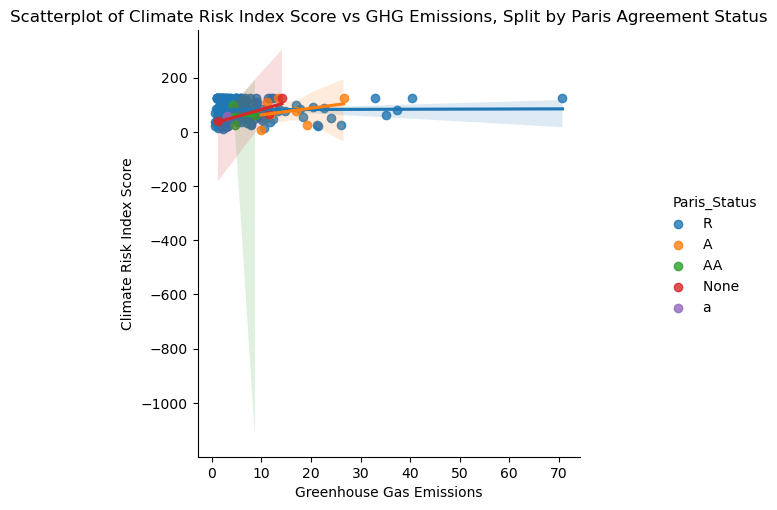

In [19]:
sns.lmplot(x = 'GHG_Emissions', y = 'CRI_SCORE', hue = "Paris_Status", data = simplified_data2)
ax = plt.gca()
ax.set_title("Scatterplot of Climate Risk Index Score vs GHG Emissions, Split by Paris Agreement Status")
ax.set_xlabel("Greenhouse Gas Emissions")
ax.set_ylabel("Climate Risk Index Score")

In [34]:
dot_chart = alt.Chart(simplified_data2).mark_circle(size = 60).encode(
    alt.X("GHG_Emissions", title = "Greenhouse Gas Emissions"),
    alt.Y("CRI_SCORE", title = "Climate Risk Index Score"),
    alt.Color("Paris_Status"),
    tooltip = [
        alt.Tooltip('Country_Name', title = "Country"),
        alt.Tooltip('GHG_Emissions',  title = "GHG Emissions"),
        alt.Tooltip('CRI_SCORE', title = "Climate Risk Score")]
).add_params(
    brush
).properties(
    width = 400,
    height = 400,
    title = "Scatterplot of Climate Risk Index Score vs GHG Emissions by Paris Agreement Status"
).interactive()

dot_chart

alt.Chart(...)

This visualization supports the results of the linear regression model: no discernable association beteween Climate Risk Index Score and Greenhouse Gas emissions can be observed. Additionally, it is difficult to draw any insight from Paris Agreement Status, as most countries included have a status of 'R' (ratified) with little variation.

Overall, there is no evidence of association between climate risk index score and greenhouse gas emissions, split across Paris Agreement status.